In [ ]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord
import os
from tqdm import tqdm
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
%load_ext tensorboard 
from tensorboard import notebook
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Bidirectional, Input, Layer, Dense, Reshape, concatenate
from keras.models import Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

     |████████████████████████████████| 19.3MB 1.3MB/s 
  Created wheel for music21: filename=music21-6.7.1-cp37-none-any.whl size=21941694 sha256=ba4d5ee3fbab353b9f8beb8209c7efcc62b46f22b26c320506f4d837a3ec8315
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MIDI_PATH="/content/drive/My Drive/MLFolder/Onlab/MIDI_Iron_Maiden/"

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Apr  4 15:57:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |   4681MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UTILITY FUNCTIONS SECTION

In [ ]:
#https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

def most_frequent(paramlist): 
    counter = 0
    num = paramlist[0] 
      
    for i in paramlist: 
        curr_frequency = paramlist.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

#Utility functions

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def create_mapper(chords):
    pitchnames = sorted(set(str(item) for item in chords))
    mapper = dict((note, number) for number, note in enumerate(pitchnames))

    return mapper

def encode_using_mapper(chords, mapper):
    encodedsong=[]
    for c in chords:
        encodedsong.append(mapper[str(c)])

    return encodedsong


def decode_chords_using_mapper(numbers, mapper):
    outputnotes = []
    for number in numbers:
        outputnotes.append(chord_from_string(get_notes_from_chord(get_key_from_value(number, mapper))))

    return outputnotes

def combine_chords_with_durations(chords, durations):
    combined = []

    for i, j in zip(chords, durations):
        i = get_notes_from_chord(str(i))
        j = get_number_from_duration(str(j))
        combined.append(i + ';' + j)

    return combined

def make_slices(data, slice_length):
    for song in tqdm(data):
        if len(song) > slice_length:

            input = []
            output = []
            slice = []

            for idx, number in enumerate(song):
                if idx < slice_length:
                    slice.append(number)

            input.append(slice.copy())
            output.append(song[slice_length])

            # Sliding window
            for idx, number in enumerate(song):
                if idx >= slice_length and (idx + 1) < len(song):
                    slice.pop(0)
                    slice.append(number)
                    input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
                    output.append(song[idx + 1])

    return input, output

def parse_everything_together(data, slice_length):

    notes=[]
    input=[]
    output=[]
    slice = []

    for song in tqdm(data):
        for number in song:
            notes.append(number)
    
    for idx, note in tqdm(enumerate(notes)):
        if idx < slice_length:
            slice.append(number)

    input.append(slice.copy())
    output.append(notes[slice_length])

    # Sliding window
    for idx, number in tqdm(enumerate(notes)):
        if idx >= slice_length and (idx + 1) < len(notes):
            slice.pop(0)
            slice.append(number)
            input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
            output.append(notes[idx + 1])
        
    return input, output

def get_key_from_value(value, dict):
    return list(dict.keys())[list(dict.values()).index(value)]

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def chord_from_string(chordstring):
    notes = chordstring.split(";")
    return chord.Chord(notes)

#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

#Source: https://github.com/alexissa32/DataScienceMusic
def create_midi_without_chords(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    First step:
    Only notes, no chords
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_without_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    Second step:
    Chords and notes
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_durations(prediction_output, output_durations, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        duration = get_number_from_duration(output_durations[i])
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_embedded_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        splitpattern = pattern.split(";")
        pattern = splitpattern[0]

        duration = get_number_from_duration(splitpattern[1])
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a chord
        elif (',' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def parse_midi_notes_and_durations():
    midiparts = []

    for file in tqdm(os.listdir(path)):
        midi = converter.parse(os.path.join(path, file))

        for part in midi.parts:
            chords=[]
            durations=[]
            for element in part.notesAndRests:
                if isinstance(element, note.Note):
                    chords.append(chord.Chord([element]))
                    durations.append(element.duration)
                elif isinstance(element, chord.Chord):
                    chords.append(element)
                    durations.append(element.duration)
                elif isinstance(element, note.Rest):
                    chords.append(element)
                    durations.append(element.duration)

            if len(chords) > 0:
                midiparts.append(MidiPart(file, part.partName, chords, durations))
            else:
                for voice in part.voices:
                    chords=[]
                    durations=[]
                    for element in voice.notesAndRests:
                        if isinstance(element, note.Note):
                            chords.append(chord.Chord([element]))
                            durations.append(element.duration)
                        elif isinstance(element, chord.Chord):
                            chords.append(element)
                            durations.append(element.duration)
                        elif isinstance(element, note.Rest):
                            chords.append(element)
                            durations.append(element.duration)

                    midiparts.append(MidiPart(file, part.partName, chords, durations))

    return midiparts

# REST

In [ ]:
class MidiPart:
    def __init__(self, song, instrument, chords, durations):
        self.song = song
        self.instrument = instrument
        self.chords = chords
        self.durations = durations


path = MIDI_PATH

IRON_MAIDEN_INSTRUMENTS = ['Acoustic Guitar', 'Viola', 'Electric Bass', 'Brass', 'Sampler', 'Electric Guitar', 'Piano', 'StringInstrument']

TARGET_INSTRUMENT = 'Electric Bass'

SLICE_LEN = 16

In [ ]:
midiparts = parse_midi_notes_and_durations()

100%|██████████| 93/93 [14:06<00:00,  9.10s/it]


In [ ]:
allchords = []
alldurations = []

TARGET_INSTRUMENT = 'Electric Bass'
for i in midiparts:
    if i.instrument == TARGET_INSTRUMENT:
        if len(i.chords)>0 :
            allchords.append(i.chords)
            alldurations.append(i.durations)

In [ ]:
mapperdata = []

for i in allchords:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)


encoded_data = []

for c in allchords:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)


restnumber = mapper['<music21.note.Rest rest>']

cleared_encoded_data=[]

for i in encoded_data:
    if most_frequent(i) != restnumber:
        cleared_encoded_data.append(i)
    else:
        pass




In [ ]:
assert(len(allchords) == len(alldurations))

combined = []
for i in range(len(allchords)):
    combined.append(combine_chords_with_durations(allchords[i], alldurations[i]))

mapperdata = []

for i in combined:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)

In [ ]:
encoded_data = []

for c in combined:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)

In [ ]:
restkeysvalues = []
for j in mapper.keys():
    if ( 'rest' in j):
        restkeysvalues.append(mapper[j])

cleared_encoded_data=[]

for i in range(len(encoded_data)):
    if most_frequent(encoded_data[i]) not in restkeysvalues:
        cleared_encoded_data.append(encoded_data[i])
    else:
        pass

In [ ]:
input, output = parse_everything_together(cleared_encoded_data, SLICE_LEN)

100%|██████████| 103/103 [00:00<00:00, 8622.16it/s]
159664it [00:00, 2838815.24it/s]
159664it [00:00, 844096.75it/s]


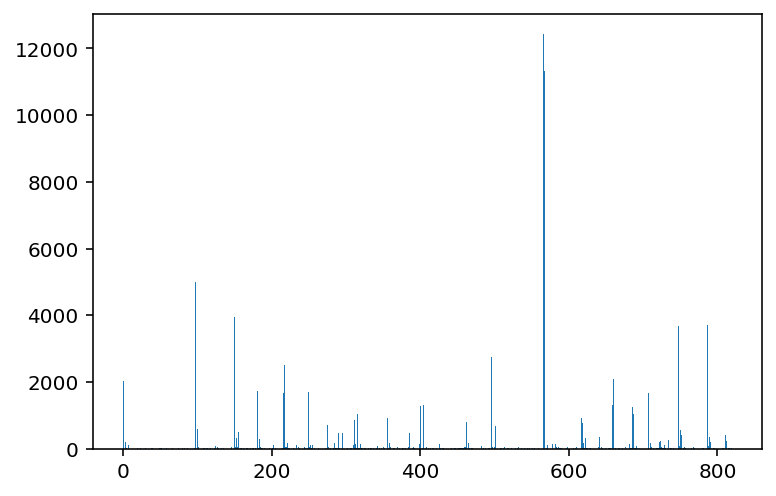

[134, 50, 281, 681, 682, 590, 709, 151, 717, 799, 9, 154, 142, 252, 255, 465, 492, 301, 571, 222, 220, 647, 490, 214, 491, 299, 375, 202, 644, 502, 728, 676, 426, 425, 607, 244, 283, 428, 342, 245, 340, 597, 333, 457, 429, 611, 598, 343, 430, 614, 53, 156, 23, 26, 711, 254, 359, 276, 737, 288, 74, 79, 205, 285, 49, 64, 56, 5, 68, 688, 749, 310, 399, 194, 195, 695, 478, 335, 766, 697, 481, 814, 171, 406, 468, 175, 169, 817, 586, 37, 508, 589, 35, 448, 192, 331, 408, 187, 318, 182, 313, 414, 580, 568, 763, 422, 66, 605, 600, 86, 101, 368, 783, 58, 546, 305, 304, 94, 379, 215, 302, 376, 795, 662, 552, 558, 556, 52, 291, 386, 392, 384, 391, 338, 332, 230, 122, 764, 390, 383, 289, 292, 177, 172, 173, 683, 157, 625, 578, 790, 316, 587, 170, 7, 511, 621, 362, 585, 500, 557, 604, 99, 218, 229, 403, 317, 325, 115, 713, 190, 324, 106, 186, 705, 204, 357, 45, 452, 532, 233, 673, 672, 447, 446, 235, 236, 451, 453, 454, 124, 126, 127, 531, 533, 534, 765, 767, 768, 545, 18, 237, 460, 128, 459, 655, 

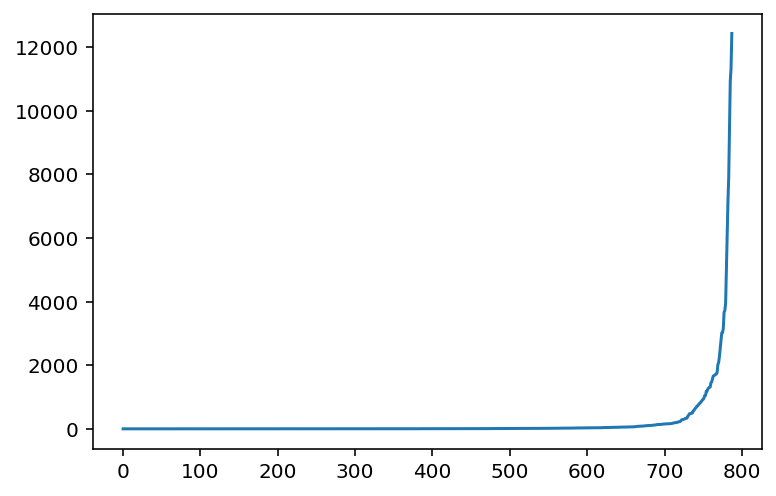

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

outputcnt = Counter(output)
plt.bar(outputcnt.keys(), outputcnt.values())
plt.show()

function_like_array=[]
for val in outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)



outliers = []

for i in outputcnt.keys():
    if outputcnt[i] < 160:
        outliers.append(i)

print(outliers)
print(len(outliers))


In [ ]:
#Because I don't want to mess up my inputs and outputs, I test their lengths before and after the outlier filtering.
assert(len(input) == len(output))

newinput=[]
newoutput=[]

for i in range(len(output)):
    if(output[i] not in outliers):
        newinput.append(input[i])
        newoutput.append(output[i])

input = newinput
output = newoutput

assert(len(input) == len(output))

In [ ]:
#However, this outlier filtering made things complicated. Now I have to make a new mapper, so that i won't end up with output classes containing 0 elements.

mapper_list = [] #Idx of the mapper list is the new value, the element is the old value.
new_output_elements = set(output)

for i in new_output_elements:
    mapper_list.append(i)

newoutput = []

for i in output:
    newoutput.append(mapper_list.index(i))

output = newoutput

In [ ]:
for i in input:
    for j in i:
        try:
            j = mapper_list.index(j)
        except ValueError:
            j = 0

In [ ]:
#Reshaping the input data to be compatible with LSTMs and normalizing it in the hope of better learning.

input = np.reshape(np.asarray(input), (len(input), SLICE_LEN, 1))
#output = to_categorical(output)

#input=np.asarray(input) / float(len(mapper))
output=np.asarray(output)

In [ ]:
SEED = 54
#np.random.seed(SEED)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.01, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED)

startidx = np.random.randint(0, len(X_test)-1)
starting_slice = X_test[startidx]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
print(startidx)
print(starting_slice)

(126440, 16, 1) (31611, 16, 1) (1597, 16, 1) (126440,) (31611,) (1597,)
1317
[[ 89]
 [ 89]
 [ 89]
 [ 89]
 [ 89]
 [ 89]
 [ 89]
 [ 98]
 [ 98]
 [ 98]
 [ 98]
 [ 98]
 [ 98]
 [ 98]
 [126]
 [ 98]]


In [ ]:
NUM_CLASSES = np.max(Y_train)+1
print(NUM_CLASSES)


134


In [ ]:
from keras.utils import Sequence

SLICE_SIZE = 16

class MyDatagen(Sequence):
  def __init__(self, list_IDs, batch_size=16, dim=(SLICE_SIZE), shuffle=True, validation=False):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.shuffle = shuffle
    self.validation=validation
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
      #Updates indexes after each epoch
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    #Generates data containing batch_size samples
    if self.validation:
      X = np.empty((self.batch_size, self.dim, 1))
      y = np.empty((self.batch_size, self.dim, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = X_val[ID]/(NUM_CLASSES-1)

        y[i] = to_categorical(X_val[ID], num_classes=NUM_CLASSES)

      return X, y
    else:
      X = np.empty((self.batch_size, self.dim, 1))
      y = np.empty((self.batch_size, self.dim, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = X_train[ID]/(NUM_CLASSES-1)

        y[i] = to_categorical(X_train[ID], num_classes=NUM_CLASSES)

      return X, y

In [ ]:
MODEL_NAME = "VAE1"

MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves/"

TBPATH = "/content/tblogs/"+MODEL_NAME

In [ ]:
#Before creating the neural network, I define some important callbacks

tb = TensorBoard(log_dir = TBPATH, write_images=True, histogram_freq=1)

plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)

es = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True, verbose=1)

callbacks = [plateau, es, tb]

In [ ]:
note_X_train = X_train
NUM_NOTES = Y_train.shape[1]

In [ ]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def make_decoder_block(initial_decoder, LSTM_cells, block_size):
    first_layer = []
    first_layer.append(initial_decoder)

    for i in range(1, block_size):
        first_layer.append(LSTM(LSTM_cells, return_sequences=True)(first_layer[i-1]))

    second_layer = []

    for i in first_layer:
        second_layer.append(LSTM(LSTM_cells)(i))

    outputs = []
    
    for i in second_layer:
        outputs.append(Dense(NUM_CLASSES, activation="softmax")(i))

    return outputs

In [ ]:
import tensorflow as tf
from keras.losses import categorical_crossentropy

class MyModel(Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def __call__(self, input):
        return self.call(input, training=False)

    def train_step(self, data):
        #x, y = data

        with tf.GradientTape() as tape:
            z = self.encoder(data[0])

            reconstruction = self.decoder(z)

            loss = tf.reduce_mean(
                tf.reduce_sum(
                    categorical_crossentropy(data[0], reconstruction)
                )
            )

            #print(f'Shape of x:{x.shape}')

            #print(f'Shape of y:{y.shape}')

            #y_pred = self(x, training=True)

            #print(f'Shape of  y_pred:{y_pred.shape}')

            #print(f'Shape of  y_pred[0]:{y_pred[0].shape}')

            #tf.print(y_pred)

            #loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            self.compiled_metrics.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
from keras.models import Sequential

LSTM_STATES = 2048
ENCODER_LSTM_CELLS = 256
latent_dim = 512
LSTM_cells = 256

notes_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name="notes_in")
x = Bidirectional(LSTM(ENCODER_LSTM_CELLS, return_sequences=True))(notes_input)
x = Bidirectional(LSTM(ENCODER_LSTM_CELLS))(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(notes_input, z, name="encoder")

#encoder.summary()

decoder_input = Input(shape=(latent_dim), name="decoder_in")
y = Dense(LSTM_cells, activation='tanh')(decoder_input)
y = Reshape((LSTM_cells, 1))(y)

conductor = LSTM(LSTM_cells, return_sequences=True)(y)
conductors = []
conductors.append(conductor)

for i in range(1, 4):
    conductors.append(LSTM(LSTM_cells, return_sequences=True)(conductors[i-1]))

initial_decoders = []

for i in conductors:
    initial_decoders.append(LSTM(LSTM_cells, return_sequences=True)(i))

final_outputs = []

for i in initial_decoders:
    for j in make_decoder_block(i, 128, 4):
        final_outputs.append(j)

#print(final_outputs[0])

out = concatenate(final_outputs, axis=1)
out = Reshape((SLICE_LEN, NUM_CLASSES))(out)

decoder = Model(decoder_input, out, name="decoder")

VAE = Sequential()
VAE.add(encoder)
VAE.add(decoder)

#VAE = Model(notes_input, out)

#VAE.summary()


In [ ]:
VAE.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
import gc
gc.collect()

2522474

In [ ]:
training_gen=MyDatagen(range(X_train.shape[0]), batch_size=16)
val_gen=MyDatagen(range(X_val.shape[0]), batch_size=16, validation=True)
#val_gen=MyDatagen(range(TRAIN_SAMPLES, TRAIN_SAMPLES+VAL_SAMPLES), validation=True)

VAE.fit(x=training_gen, validation_data=val_gen, callbacks=callbacks, epochs=100)

Epoch 1/100
6694/7902 [========================>.....] - ETA: 11:04 - loss: 2.9926 - accuracy: 0.1667

In [ ]:
PLOT = False

for i in range(1000):
    noise = np.random.normal(size=512)
    if PLOT:
        plt.plot(noise)
        plt.show()
    noise = np.expand_dims(noise, 0)
    pred = decoder.predict(noise)
    predicted = []
    for j in np.argmax(pred, axis=2)[0]:
        if (j!=89): #E2 hang konstansa
            predicted.append(get_key_from_value(j, mapper))
    if len(predicted) > 0:
        print(predicted)

['<music21.chord.Chord E-2 G#1>', '<music21.chord.Chord A1 D2 A2>', '<music21.chord.Chord D3 D4>', '<music21.chord.Chord B2 C3>', '<music21.chord.Chord B2 C3>', '<music21.chord.Chord D2 F#2>', '<music21.chord.Chord A1 D2 A2>', '<music21.chord.Chord B1 F#2>', '<music21.chord.Chord E2 E3>', '<music21.chord.Chord G#3 C#3 G#2>', '<music21.chord.Chord F3 C3>', '<music21.chord.Chord E1 E2 B2>', '<music21.chord.Chord E-3 G#2>', '<music21.chord.Chord F2 C2 F1>', '<music21.chord.Chord E-3 B-2 E-2>', '<music21.chord.Chord B1 B2>']
['<music21.chord.Chord E-2 G#1>', '<music21.chord.Chord A1 D2 A2>', '<music21.chord.Chord D3 D4>', '<music21.chord.Chord B2 C3>', '<music21.chord.Chord B2 C3>', '<music21.chord.Chord D2 F#2>', '<music21.chord.Chord A1 D2 A2>', '<music21.chord.Chord B1 F#2>', '<music21.chord.Chord E2 E3>', '<music21.chord.Chord G#3 C#3 G#2>', '<music21.chord.Chord F3 C3>', '<music21.chord.Chord E1 E2 B2>', '<music21.chord.Chord E-3 G#2>', '<music21.chord.Chord F2 C2 F1>', '<music21.chor

In [ ]:
print(pred.shape)
print(pred)



(1, 16, 134)
[[[4.04486354e-06 1.20049635e-05 2.67812193e-05 ... 4.65139234e-03
   1.39672411e-04 3.18176597e-02]
  [5.81615076e-08 4.60803312e-06 5.09726960e-05 ... 3.60132847e-03
   1.26709914e-04 3.79230306e-02]
  [4.47331558e-06 1.00024511e-06 6.40938524e-05 ... 4.03104443e-03
   1.70278290e-04 3.53804417e-02]
  ...
  [6.50238826e-06 2.38026860e-06 6.36392142e-05 ... 4.57334472e-03
   1.03141203e-04 3.86161469e-02]
  [4.87724446e-06 3.87218279e-07 3.89045017e-05 ... 4.19295812e-03
   6.82816753e-05 3.34177278e-02]
  [2.21004211e-06 7.48976345e-06 4.49367835e-05 ... 3.85767268e-03
   1.10283443e-04 3.33267786e-02]]]
['<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music21.chord.Chord E2>', '<music2

In [ ]:
print(pred.shape)

(1, 16, 134)


In [ ]:
VAE.save(MODEL_SAVE_PATH+MODEL_NAME+".h5")